# Rete Neurale

Caricamento delle librerie

In [1]:
import os
import pandas as pd
from numpy import loadtxt
import numpy as np
import datetime
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

# For LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model

#from ann_visualizer.visualize import ann_viz
from keras.utils.vis_utils import plot_model

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# Themes
# "seaborn", 'ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff', 'ygridoff', 'gridon', 'none'
pio.templates.default = "presentation" 

from plotly.subplots import make_subplots

Using TensorFlow backend.


Seleziona cartelle e carica file

In [2]:
# select data folder_dati
glob_path = os.path.normpath(os.getcwd() + os.sep + os.pardir)
folder_dati = glob_path+R"//dati"
folder_risultati = glob_path+R"//risultati"

In [3]:
files = os.listdir(folder_risultati)
files[0:]

['df_hour.csv',
 'shampoo.csv',
 'df_grouped_date.csv',
 'df_grouped_date_risorsa.csv',
 'df_grouped_hour.csv',
 'export.csv',
 'df_grouped_date_cama_nosunday.csv',
 'export.xlsx',
 'df_min_ciclo_nosunday_no0.csv',
 'df_grouped_date_nosunday.csv']

In [4]:
# Load df_grouped_date, original file
df = pd.read_csv(folder_risultati+"/df_grouped_date_nosunday.csv", sep = ",")
df2 = pd.read_csv(folder_risultati+"/df_min_ciclo_nosunday_no0.csv", sep = ",")
df = df2

In [5]:
# substitute null values with 0
df['Minuti ciclo'] = df['Minuti ciclo'].fillna(0)
#df['Minuti NO ciclo'] = df['Minuti NO ciclo'].fillna(0)
#df['Efficienza'] = df['Efficienza'].fillna(0)

# convert Date 
df['Date'] = pd.to_datetime(df["Date"], format='%Y-%m-%d')

# convert minuti ciclo, no ciclo, efficienza to double
df['Minuti ciclo'] = df['Minuti ciclo'].replace(',', '.', regex=True).astype(float)
#df['Minuti NO ciclo'] = df['Minuti NO ciclo'].replace(',', '.', regex=True).astype(float)
#df['Efficienza'] = df['Efficienza'].replace(',', '.', regex=True).astype(float)

In [6]:
df

Date  Minuti ciclo
0   2019-01-01   1199.102987
1   2019-01-02   1199.102987
2   2019-01-03   1199.102987
3   2019-01-04   1199.102987
4   2019-01-05   1199.102987
..         ...           ...
486 2020-07-21   1881.433333
487 2020-07-22   2074.900000
488 2020-07-23   2184.450000
489 2020-07-24   2052.766667
490 2020-07-25    775.850000

[491 rows x 2 columns]

In [7]:
# plot general efficiency
fig = px.line(df, x = "Date", y = "Minuti ciclo", 
              title = "Efficienza / giorno Totale delle macchine")
fig.show()

Seleziona train e test

In [8]:
train = df[:313]

# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(train[['Minuti ciclo']])

# Scale predicted value
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(train[['Minuti ciclo']])

Usa una finestra di osservazioni di 7 giorni per far girare la rete neurale

In [9]:
# Each time step uses last 'window' to predict the next change
window = 6
X = []
Y = []
for i in range(window,len(Xs)):
    X.append(Xs[i-window:i,:])
    Y.append(Ys[i])

# Reshape data to format accepted by LSTM
X, Y = np.array(X), np.array(Y)

Crea il modello e lo alleni

In [42]:
# create and train LSTM model

# Initialize LSTM model
model1 = Sequential()

model1.add(LSTM(units=50, return_sequences=True, \
          input_shape=(X.shape[1],X.shape[2])))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))
model1.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])

In [43]:
# Allow for early exit
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

# Fit (and time) LSTM model
t0 = time.time()
history = model1.fit(X, Y, epochs = 20, batch_size = 250, callbacks=[es], verbose=1)
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))



Epoch 1/20
307/307 [==============================] - 8s 27ms/step - loss: 0.1842 - accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 883us/step - loss: 0.1737 - accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1601 - accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1507 - accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 861us/step - loss: 0.1426 - accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1379 - accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 912us/step - loss: 0.1312 - accuracy: 0.0000e+00
Epoch 8/20
307/307 [==============================] - 0s 883us/step - loss: 0.1208 - accuracy: 0.0000e+00
Epoch 9/20
307/307 [==============================] - 0s 990us/step - loss: 0.1182 - accuracy: 0.0000e+00
Epoch 10/20
307/307 [==============================] 

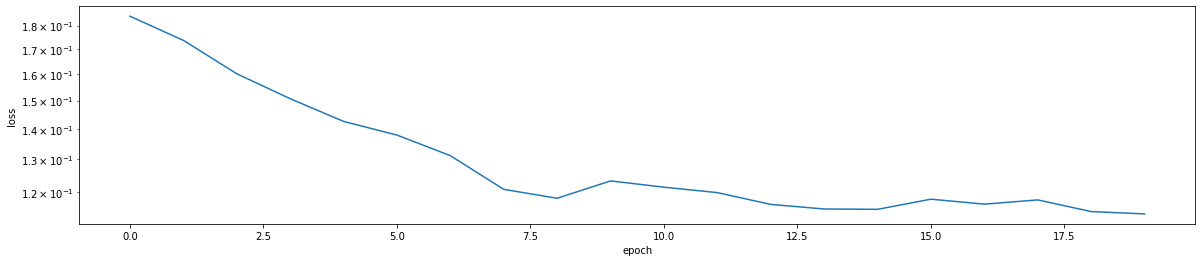

In [44]:
# Plot loss
plt.figure(figsize=(20,4))
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')

# Verify the fit of the model
Yp = model1.predict(X)



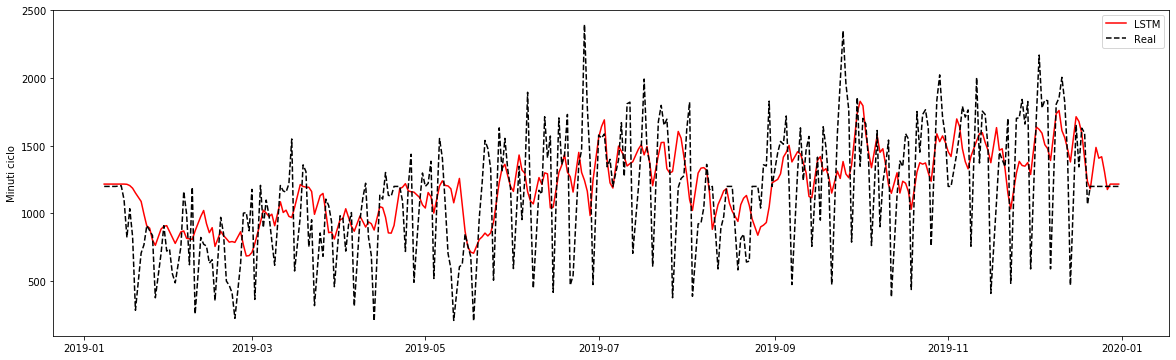

In [45]:
# un-scale outputs
Yu = s2.inverse_transform(Yp)
Ym = s2.inverse_transform(Y)

plt.figure(figsize=(20,6))
plt.subplot(1,1,1)
plt.plot(train['Date'][window:],Yu,'r-',label='LSTM')
plt.plot(train['Date'][window:],Ym,'k--',label='Real')
plt.ylabel('Minuti ciclo')
plt.legend()

In [47]:
# RMSE on train
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse1_train = sqrt(mean_squared_error(Ym, Yu))
rmse1_train

367.50454307753205

In [48]:
# Load model
v = model1

# Load testing data
test = df[313:497]

Xt = test[['Minuti ciclo']].values
Yt = test[['Minuti ciclo']].values

Xts = s1.transform(Xt)
Yts = s2.transform(Yt)

Xti = []
Yti = []
for i in range(window,len(Xts)):
    Xti.append(Xts[i-window:i,:])
    Yti.append(Yts[i])

# Reshape data to format accepted by LSTM
Xti, Yti = np.array(Xti), np.array(Yti)

# Verify the fit of the model
Ytp = model.predict(Xti)



Text(0, 0.5, 'Minuti ciclo')

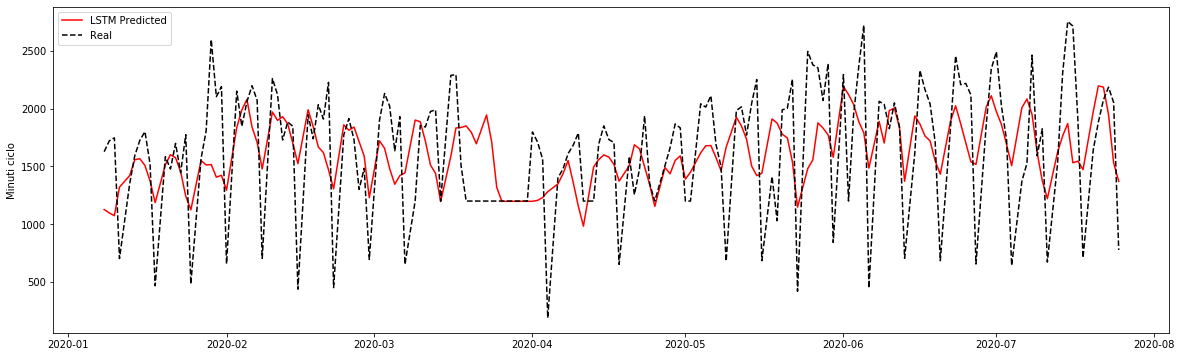

In [49]:
# un-scale outputs
Ytu = s2.inverse_transform(Ytp) # predicted
Ytm = s2.inverse_transform(Yti) # real

plt.figure(figsize=(20,6))
plt.subplot(1,1,1)
plt.plot(test['Date'][window:],Ytu,'r-',label='LSTM Predicted')
plt.plot(test['Date'][window:],Ytm,'k--',label='Real')
plt.legend()
plt.ylabel('Minuti ciclo')

In [50]:
Ytu

array([[1125.9178],
       [1096.2533],
       [1072.2775],
       [1319.4241],
       [1419.3767],
       [1557.2017],
       [1565.6034],
       [1506.4086],
       [1372.3696],
       [1185.5491],
       [1513.005 ],
       [1600.627 ],
       [1574.136 ],
       [1452.567 ],
       [1241.4906],
       [1122.9775],
       [1549.6477],
       [1511.6792],
       [1515.3109],
       [1406.0402],
       [1421.8813],
       [1293.042 ],
       [1834.1118],
       [1988.4983],
       [2079.2297],
       [1840.4978],
       [1706.9658],
       [1476.6826],
       [1969.8573],
       [1897.5212],
       [1929.8744],
       [1867.6793],
       [1699.5088],
       [1522.9286],
       [1989.6483],
       [1843.7168],
       [1667.0752],
       [1618.5016],
       [1469.5311],
       [1304.6122],
       [1858.7566],
       [1812.3206],
       [1839.7657],
       [1715.2526],
       [1588.31  ],
       [1228.1305],
       [1720.0905],
       [1656.1368],
       [1479.3445],
       [1344.731 ],


Calcola indice RMSE

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
pred = Ytu[:201]
real = Ytm[:201]

rmse1_test = sqrt(mean_squared_error(real, pred))
rmse1_test

484.74732633053304

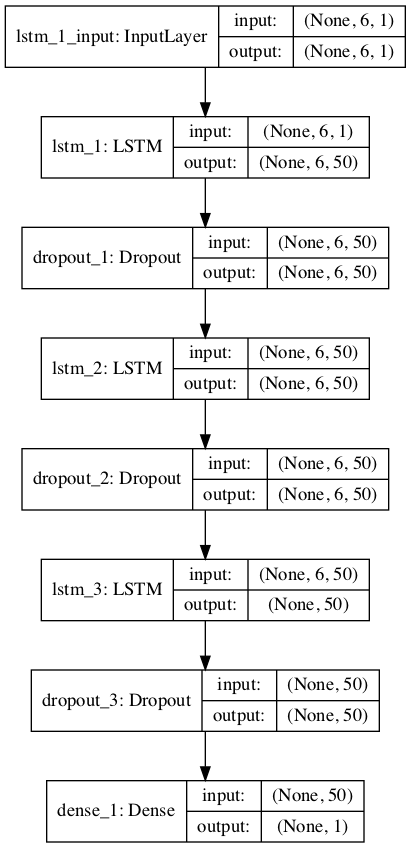

In [52]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [53]:
# second structure

# Initialize LSTM model
model2 = Sequential()

model2.add(LSTM(units=50, return_sequences=True, \
          input_shape=(X.shape[1],X.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(units=30))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))
model2.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])


In [54]:
# Allow for early exit
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

# Fit (and time) LSTM model
t0 = time.time()
history = model2.fit(X, Y, epochs = 20, batch_size = 250, callbacks=[es], verbose=1)
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))



Epoch 1/20
307/307 [==============================] - 5s 17ms/step - loss: 0.2041 - accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 518us/step - loss: 0.1892 - accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 629us/step - loss: 0.1736 - accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 637us/step - loss: 0.1600 - accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 642us/step - loss: 0.1495 - accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 972us/step - loss: 0.1431 - accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1372 - accuracy: 0.0000e+00
Epoch 8/20
307/307 [==============================] - 0s 678us/step - loss: 0.1319 - accuracy: 0.0000e+00
Epoch 9/20
307/307 [==============================] - 0s 523us/step - loss: 0.1248 - accuracy: 0.0000e+00
Epoch 10/20
307/307 [============================

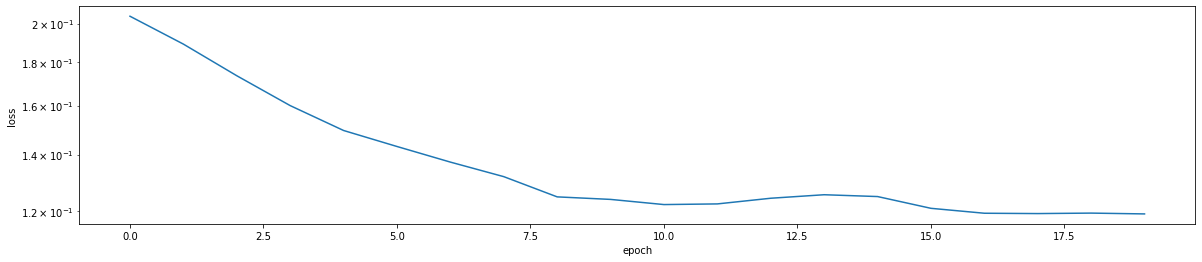

In [55]:
# Plot loss
plt.figure(figsize=(20,4))
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')

# Verify the fit of the model
Yp = model2.predict(X)



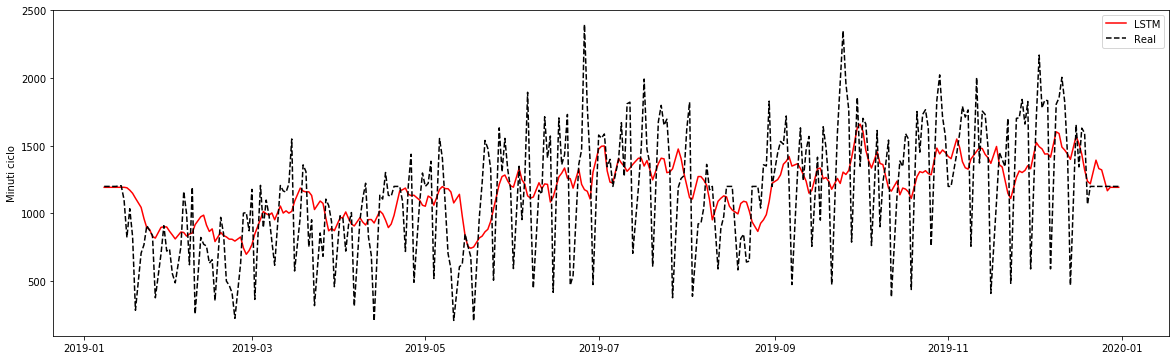

In [56]:
# un-scale outputs
Yu = s2.inverse_transform(Yp)
Ym = s2.inverse_transform(Y)

plt.figure(figsize=(20,6))
plt.subplot(1,1,1)
plt.plot(train['Date'][window:],Yu,'r-',label='LSTM')
plt.plot(train['Date'][window:],Ym,'k--',label='Real')
plt.ylabel('Minuti ciclo')
plt.legend()

In [57]:
# RMSE on train
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse2_train = sqrt(mean_squared_error(Ym, Yu))
rmse2_train

376.8478492015935

In [58]:
# Load model
v = model2

# Load testing data
test = df[313:497]

Xt = test[['Minuti ciclo']].values
Yt = test[['Minuti ciclo']].values

Xts = s1.transform(Xt)
Yts = s2.transform(Yt)

Xti = []
Yti = []
for i in range(window,len(Xts)):
    Xti.append(Xts[i-window:i,:])
    Yti.append(Yts[i])

# Reshape data to format accepted by LSTM
Xti, Yti = np.array(Xti), np.array(Yti)

# Verify the fit of the model
Ytp = model2.predict(Xti)



Text(0, 0.5, 'Minuti ciclo')

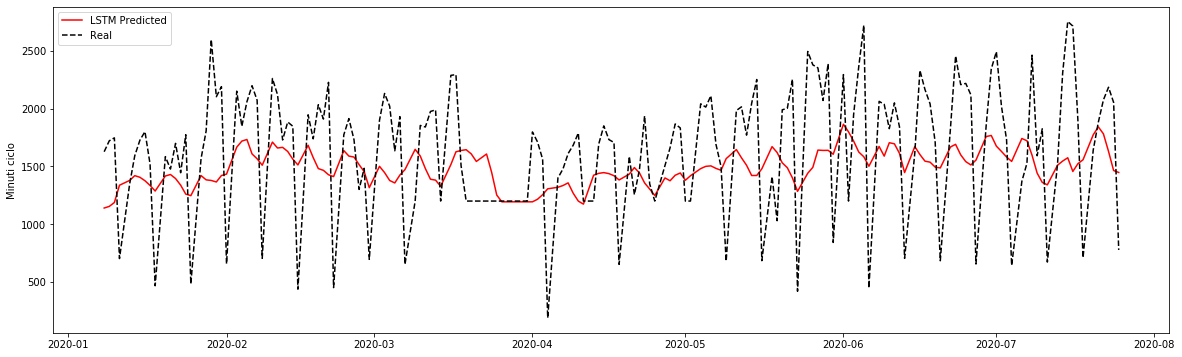

In [59]:
# un-scale outputs
Ytu = s2.inverse_transform(Ytp) # predicted
Ytm = s2.inverse_transform(Yti) # real

plt.figure(figsize=(20,6))
plt.subplot(1,1,1)
plt.plot(test['Date'][window:],Ytu,'r-',label='LSTM Predicted')
plt.plot(test['Date'][window:],Ytm,'k--',label='Real')
plt.legend()
plt.ylabel('Minuti ciclo')

In [60]:
from sklearn.metrics import mean_squared_error
from math import sqrt
pred = Ytu[:201]
real = Ytm[:201]

rmse2_test = sqrt(mean_squared_error(real, pred))
rmse2_test

542.7180529170251

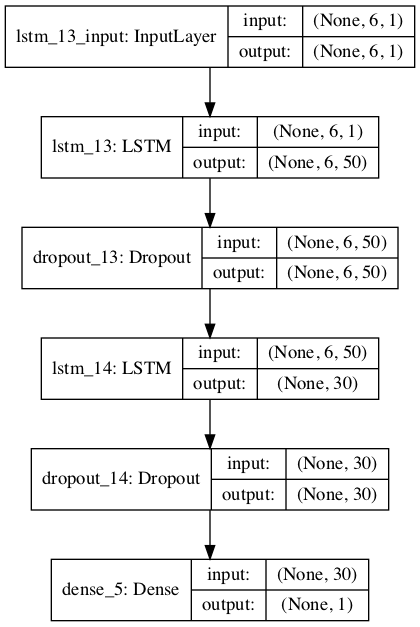

In [61]:
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [82]:
# third structure

# Initialize LSTM model
model3 = Sequential()

model3.add(LSTM(units=50, return_sequences=True, \
          input_shape=(X.shape[1],X.shape[2])))
model3.add(Dropout(0.2))
model3.add(LSTM(units=50, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=40, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=40))
model3.add(Dropout(0.2))
model3.add(Dense(units=1))
model3.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])


In [83]:
# Allow for early exit
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

# Fit (and time) LSTM model
t0 = time.time()
history = model3.fit(X, Y, epochs = 20, batch_size = 250, callbacks=[es], verbose=1)
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))



Epoch 1/20
307/307 [==============================] - 15s 48ms/step - loss: 0.1821 - accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1751 - accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1664 - accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1578 - accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1518 - accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1385 - accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1232 - accuracy: 0.0000e+00
Epoch 8/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1126 - accuracy: 0.0000e+00
Epoch 9/20
307/307 [==============================] - 0s 1ms/step - loss: 0.1256 - accuracy: 0.0000e+00
Epoch 10/20
307/307 [==============================] - 0s 1ms/

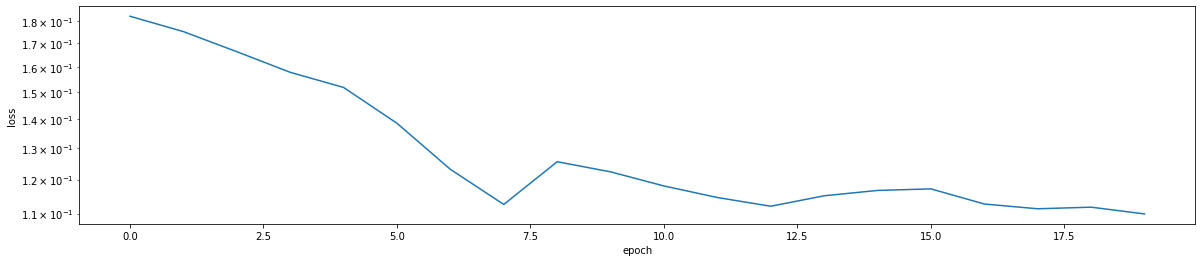

In [84]:
# Plot loss
plt.figure(figsize=(20,4))
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')

# Verify the fit of the model
Yp = model3.predict(X)



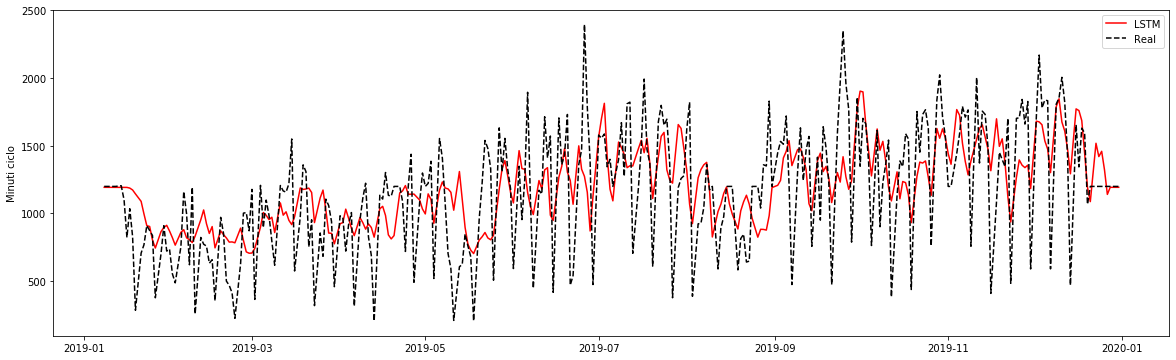

In [85]:
# un-scale outputs
Yu = s2.inverse_transform(Yp)
Ym = s2.inverse_transform(Y)

plt.figure(figsize=(20,6))
plt.subplot(1,1,1)
plt.plot(train['Date'][window:],Yu,'r-',label='LSTM')
plt.plot(train['Date'][window:],Ym,'k--',label='Real')
plt.ylabel('Minuti ciclo')
plt.legend()

In [86]:
# RMSE on train
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse3_train = sqrt(mean_squared_error(Ym, Yu))
rmse3_train

359.92569612516826

In [87]:
# Load model
v = model3

# Load testing data
test = df[313:497]

Xt = test[['Minuti ciclo']].values
Yt = test[['Minuti ciclo']].values

Xts = s1.transform(Xt)
Yts = s2.transform(Yt)

Xti = []
Yti = []
for i in range(window,len(Xts)):
    Xti.append(Xts[i-window:i,:])
    Yti.append(Yts[i])

# Reshape data to format accepted by LSTM
Xti, Yti = np.array(Xti), np.array(Yti)

# Verify the fit of the model
Ytp = model3.predict(Xti)



Text(0, 0.5, 'Minuti ciclo')

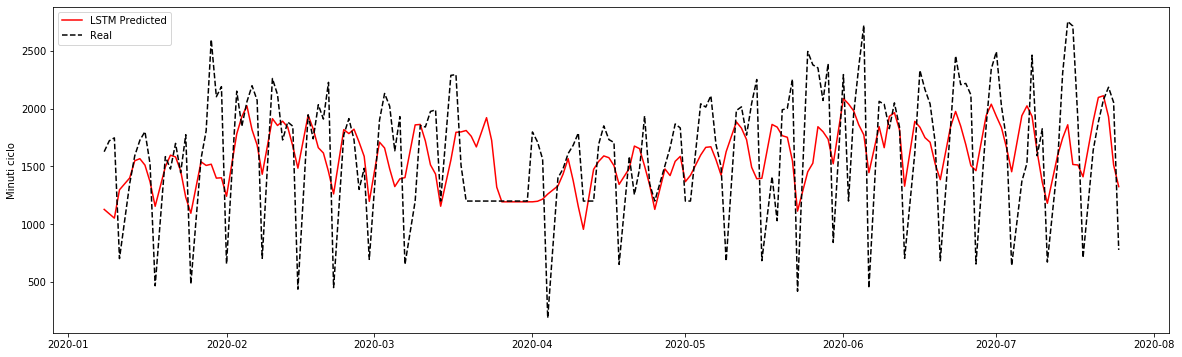

In [88]:
# un-scale outputs
Ytu = s2.inverse_transform(Ytp) # predicted
Ytm = s2.inverse_transform(Yti) # real

plt.figure(figsize=(20,6))
plt.subplot(1,1,1)
plt.plot(test['Date'][window:],Ytu,'r-',label='LSTM Predicted')
plt.plot(test['Date'][window:],Ytm,'k--',label='Real')
plt.legend()
plt.ylabel('Minuti ciclo')

In [89]:
from sklearn.metrics import mean_squared_error
from math import sqrt
pred = Ytu[:201]
real = Ytm[:201]

rmse3_test = sqrt(mean_squared_error(real, pred))
rmse3_test

478.9465875974628

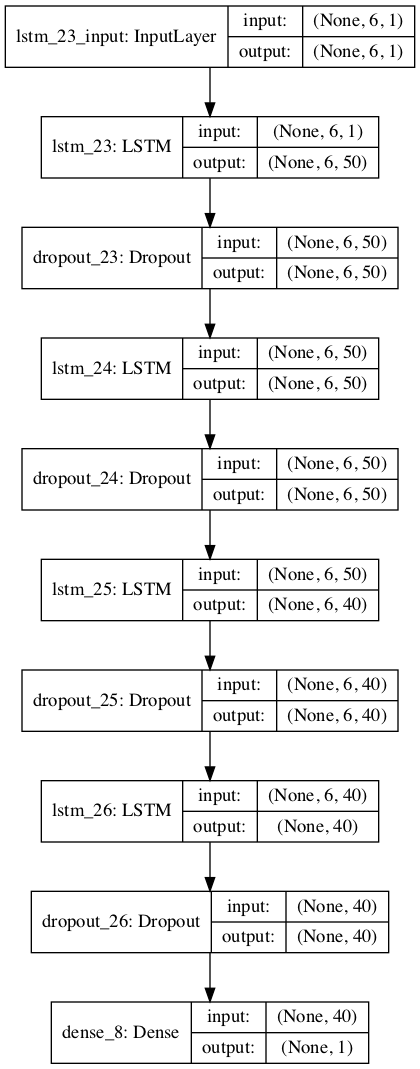

In [90]:
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [72]:
# 4 structure

# Initialize LSTM model
model4 = Sequential()

model4.add(LSTM(units=50, return_sequences=True, \
          input_shape=(X.shape[1],X.shape[2])))
model4.add(Dropout(0.2))
model4.add(LSTM(units=50, return_sequences=True))
model4.add(Dropout(0.2))
model4.add(LSTM(units=40, return_sequences=True))
model4.add(Dropout(0.2))
model4.add(LSTM(units=40))
model4.add(Dropout(0.2))
model4.add(Dense(units=1))
model4.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])


In [73]:
# Allow for early exit
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

# Fit (and time) LSTM model
t0 = time.time()
history = model4.fit(X, Y, epochs = 50, batch_size = 250, callbacks=[es], verbose=1)
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))



Epoch 1/50
307/307 [==============================] - 12s 38ms/step - loss: 0.1824 - accuracy: 0.0000e+00
Epoch 2/50
307/307 [==============================] - 0s 1ms/step - loss: 0.1739 - accuracy: 0.0000e+00
Epoch 3/50
307/307 [==============================] - 0s 1ms/step - loss: 0.1647 - accuracy: 0.0000e+00
Epoch 4/50
307/307 [==============================] - 0s 1ms/step - loss: 0.1549 - accuracy: 0.0000e+00
Epoch 5/50
307/307 [==============================] - 0s 1ms/step - loss: 0.1512 - accuracy: 0.0000e+00
Epoch 6/50
307/307 [==============================] - 0s 1ms/step - loss: 0.1412 - accuracy: 0.0000e+00
Epoch 7/50
307/307 [==============================] - 0s 1ms/step - loss: 0.1220 - accuracy: 0.0033
Epoch 8/50
307/307 [==============================] - 0s 1ms/step - loss: 0.1153 - accuracy: 0.0000e+00
Epoch 9/50
307/307 [==============================] - 0s 1ms/step - loss: 0.1183 - accuracy: 0.0000e+00
Epoch 10/50
307/307 [==============================] - 1s 2ms/step

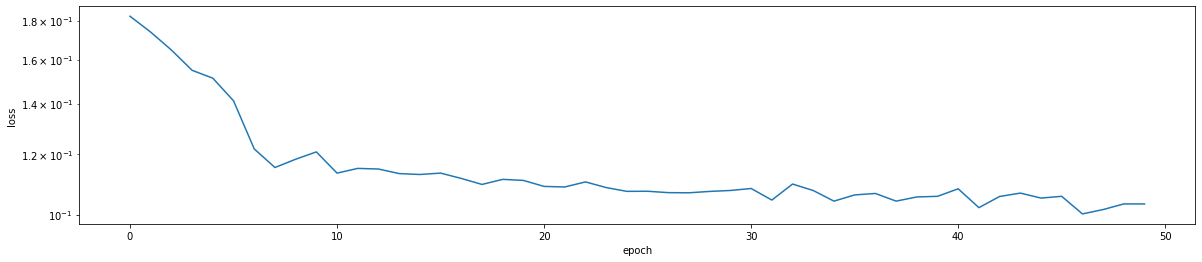

In [74]:
# Plot loss
plt.figure(figsize=(20,4))
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')

# Verify the fit of the model
Yp = model4.predict(X)



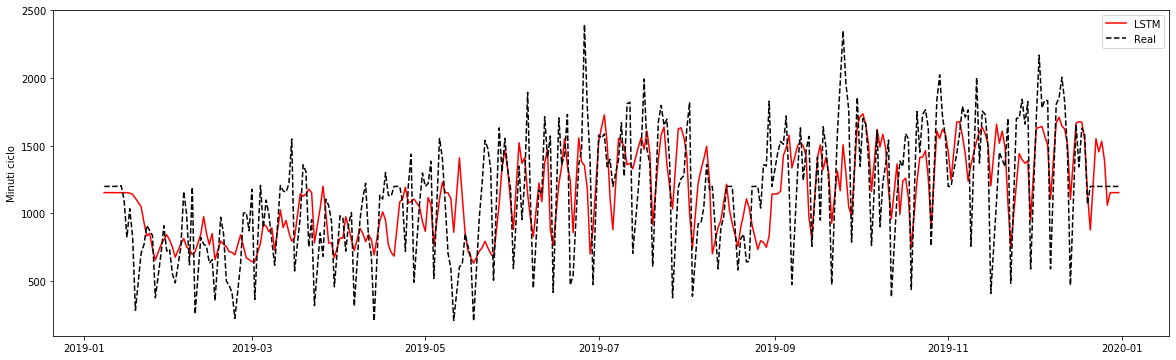

In [75]:
# un-scale outputs
Yu = s2.inverse_transform(Yp)
Ym = s2.inverse_transform(Y)

plt.figure(figsize=(20,6))
plt.subplot(1,1,1)
plt.plot(train['Date'][window:],Yu,'r-',label='LSTM')
plt.plot(train['Date'][window:],Ym,'k--',label='Real')
plt.ylabel('Minuti ciclo')
plt.legend()

In [76]:
# RMSE on train
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse4_train = sqrt(mean_squared_error(Ym, Yu))
rmse4_train

348.93628728667926

In [77]:
# Load model
v = model4

# Load testing data
test = df[313:497]

Xt = test[['Minuti ciclo']].values
Yt = test[['Minuti ciclo']].values

Xts = s1.transform(Xt)
Yts = s2.transform(Yt)

Xti = []
Yti = []
for i in range(window,len(Xts)):
    Xti.append(Xts[i-window:i,:])
    Yti.append(Yts[i])

# Reshape data to format accepted by LSTM
Xti, Yti = np.array(Xti), np.array(Yti)

# Verify the fit of the model
Ytp = model4.predict(Xti)



Text(0, 0.5, 'Minuti ciclo')

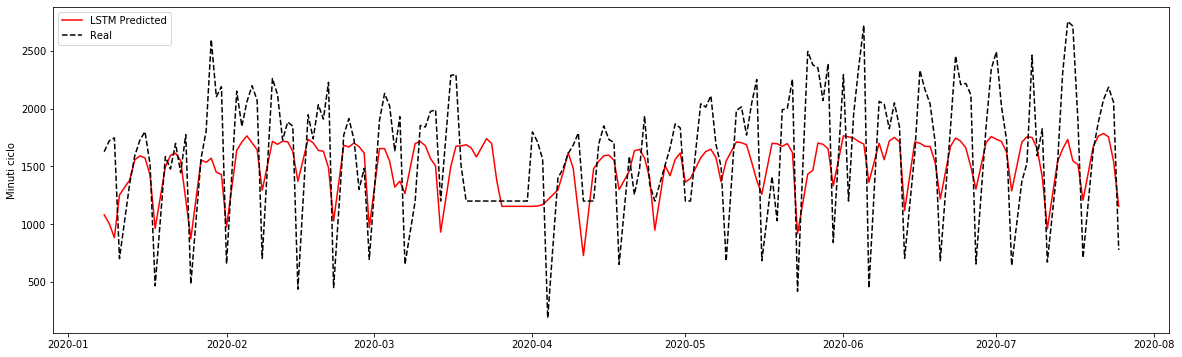

In [78]:
# un-scale outputs
Ytu = s2.inverse_transform(Ytp) # predicted
Ytm = s2.inverse_transform(Yti) # real

plt.figure(figsize=(20,6))
plt.subplot(1,1,1)
plt.plot(test['Date'][window:],Ytu,'r-',label='LSTM Predicted')
plt.plot(test['Date'][window:],Ytm,'k--',label='Real')
plt.legend()
plt.ylabel('Minuti ciclo')

In [79]:
from sklearn.metrics import mean_squared_error
from math import sqrt
pred = Ytu[:201]
real = Ytm[:201]

rmse4_test = sqrt(mean_squared_error(real, pred))
rmse4_test

467.9096202280408

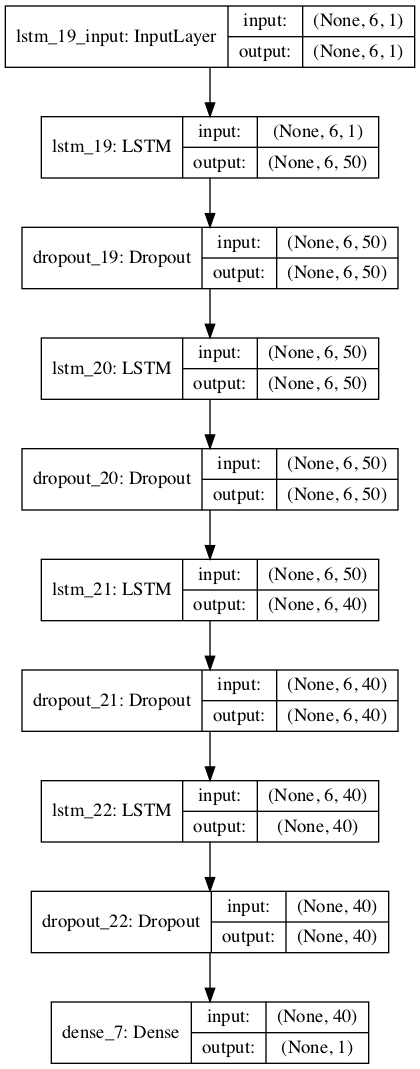

In [80]:
plot_model(model4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [91]:
print(rmse1_train, rmse1_test, rmse2_train, rmse2_test, rmse3_train, rmse3_test, rmse4_train, rmse4_test)

367.50454307753205 484.74732633053304 376.8478492015935 542.7180529170251 359.92569612516826 478.9465875974628 348.93628728667926 467.9096202280408
